# **Visual Transformer** for Image Classification with **PyTorch**

in this notebook, we implement the model architecture proposed by the paper:

*"An Image Is Worth 16x16 Words"* for **computer vision** implementation

## architecture information

the objective of the paper is to bring the popular **transformer models** that are so predominant in the **NLP** field to **Computer Vision** applications objectiving to create a competitior to the widlely used **CNN's**

### overview

the model begins splitting the image into *patches* (that are like segmantations or slices of the image that are usualy squared) --> in the paper they use patches of **16x16**

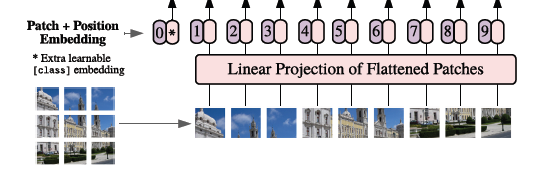

the patches are then **flattened** passed into a **postion embedding**

# ----- MORE THEORY -----

## Coding `ViT` from scratch

In [1]:
# import
import torch
from torch import nn

In [39]:
# hyperparameters
LR = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROP_PROB = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM  = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
BATCH_SIZE = 512
NUM_EPOCHS = 3

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embedding + x
        x = self.dropout(x) 
        return x

In [10]:
# test class
test_model = PatchEmbedding(embed_dim=EMBED_DIM,
                            patch_size=PATCH_SIZE,
                            num_patches=NUM_PATCHES,
                            dropout=DROP_PROB,
                            in_channels=IN_CHANNELS)

rand_test = torch.rand(size=(3, IN_CHANNELS, IMG_SIZE, IMG_SIZE))

print(f'output shape: {test_model(rand_test).shape}  (batch_size, num of tokens,  patch_size_flattened)')

output shape: torch.Size([3, 50, 16])  (batch_size, num of tokens,  patch_size_flattened)


In [12]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self. embeddings_block = PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size, num_patches=num_patches, dropout=dropout, in_channels=in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [28]:
model = ViT(num_patches=NUM_PATCHES,
                 num_classes=NUM_CLASSES,
                 patch_size=PATCH_SIZE,
                 embed_dim=EMBED_DIM,
                 num_encoders=NUM_ENCODERS,
                 num_heads=NUM_HEADS,
                 hidden_dim=HIDDEN_DIM,
                 dropout=DROP_PROB,
                 activation=ACTIVATION,
                 in_channels=IN_CHANNELS,
                 img_size=IMG_SIZE)

model(rand_test).shape

torch.Size([3, 10])

to train our `ViT` model we'll use a the widely used `MNIST` dataset that is built-in `torchvision`

In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

train_data = datasets.MNIST(root='./data', train=True, transform=data_transform, target_transform=None, download=True)

test_data = datasets.MNIST(root='./data', train=False, target_transform=None, transform=data_transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 68830882.14it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28821245.26it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47823441.85it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


100%|██████████| 4542/4542 [00:00<00:00, 9115085.53it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [19]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             drop_last=True)

len(train_dataloader), len(test_dataloader)

(117, 19)

pick `optimizer`, `loss function` and define accuracy metric

In [29]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def acc(y_true, y_pred):
    compare = torch.eq(y_true, y_pred)
    count = 0
    for boolean in compare:
        if boolean == True:
            count += 1
    return round((count/len(y_true)) * 100, 2)

optim = Adam(params=model.parameters(), betas=ADAM_BETAS, lr=LR, weight_decay=ADAM_WEIGHT_DECAY)

loss_fn = CrossEntropyLoss()

In [32]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([3, 2, 3])

acc(a, b)

66.67

now we write `train_step()` & `test_step()` loop functions

In [41]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim,
               loss_fn: torch.nn,
               batch_size: int):
    
    train_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        model.train()
        # 1. forward pass
        pred = model(x)

        # 2. calculate the loss
        loss = loss_fn(pred, y)
        train_loss += loss
        
        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        if batch % 40 == 0:
            print(f'model looked at: {batch*BATCH_SIZE} of a total of {BATCH_SIZE * len(dataloader)} samples')

    train_loss /= len(dataloader)

    print(f'training epoch finished!')
    print(f'-----------------------')
    print(f'loss: {train_loss}')
    print(f'-----------------------')
    return train_loss

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn,
              metric,
              batch_size: int):
    
    test_loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for x, y in dataloader:
            pred = model(x)

            test_loss += loss_fn(pred, y)
            acc += metric(y, pred.argmax(dim=1))

        test_loss /= len(dataloader)
        acc /= len(dataloader)
    print(f'test epoch finished!')
    print(f'-------------------')
    print(f'test loss: {test_loss}')
    print(f'accuracy: {acc}')
    print(f'-------------------')


def full_test_loop(model: nn.Module,
                   train_dataloader: torch.utils.data.dataloader,
                   test_dataloader: torch.utils.data.dataloader,
                   optimizer: torch.optim,
                   loss_fn: nn.Module,
                   metric,
                   batch_size: int,
                   num_epochs: int):
           
    for epoch in range(num_epochs):
        print(f'epoch: {epoch}')

        train_step(model=model,
                   dataloader=train_dataloader,
                   optimizer=optimizer,
                   loss_fn=loss_fn,
                   batch_size=batch_size)
        
        test_step(model=model,
                  dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  metric=metric,
                  batch_size=batch_size)
        
    return train_step, test_step



In [42]:
full_test_loop(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optim,
               loss_fn=loss_fn,
               metric=acc,
               batch_size=BATCH_SIZE,
               num_epochs=NUM_EPOCHS)

epoch: 0
model looked at: 0 of a total of 59904 samples
model looked at: 20480 of a total of 59904 samples
model looked at: 40960 of a total of 59904 samples
training epoch finished!
-----------------------
loss: 1.33087956905365
-----------------------
test epoch finished!
-------------------
test loss: 1.1523911952972412
accuracy: 72.09105263157895
-------------------
epoch: 1
model looked at: 0 of a total of 59904 samples


KeyboardInterrupt: 